## Import modules

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smformula
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Load the combined dataset and inspect it

#### Drop rows where envProduction is NaN

In [2]:
# print number of rows in the dataset
data = pd.read_csv('./output/roundlevel_combined7.csv', index_col=0)
print(len(data))
# drop rows where envProduction is NaN 
data.dropna(subset=['envProduction'], inplace=True)
print(len(data))

17083
14351


In [3]:
np.unique([x[:-2] for x in data.columns.values])

array(['Age', 'Education', 'Game', 'Gender', 'Rel1', 'Rel2', 'Rel3',
       'RespHOH', 'Roun', 'Treatmen', 'count', 'e', 'envProducti',
       'primary_farming', 'producti', 'subsi'], dtype='<U15')

#### Box-plots showing country-wise distribution of the environmental production outcome

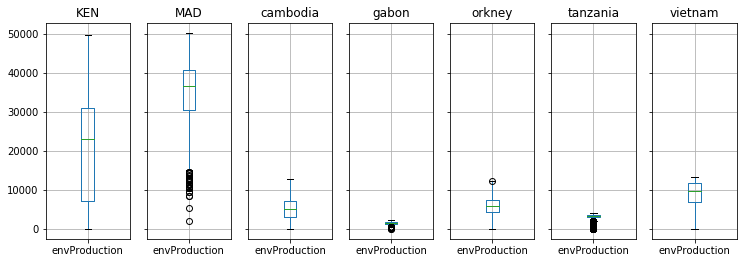

In [4]:
data[['envProduction', 'country']].groupby('country').boxplot(figsize=(12,4), layout=(1,7))
plt.show()

## Compute group statistics (mean, variance, min, max)

In [5]:
for col in ['Age', 'Education', 'Gender', 'RespHOH', 'primary_farming']:
    data[col+'_mean'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].mean(axis=1)
    #data[col+'_std'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].std(axis=1)
    data[col+'_var'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].var(axis=1)
    data[col+'_min'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].min(axis=1)
    data[col+'_max'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].max(axis=1)

data['rel_mean'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].mean(axis=1)
data['rel_var'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].var(axis=1)
data['rel_min'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].min(axis=1)
data['rel_max'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].max(axis=1)

#### One-hot encode the country column

In [6]:
# Get one hot encoding of country column
one_hot = pd.get_dummies(data['country'])
# Join the encoded dataframe
data = pd.concat([data, one_hot], axis=1)

In [7]:
data['GameID'] = data['GameID'].astype(str)

## Compute column-wise z-scores (separately for every subset of dataset)

In [8]:
col_list = ['Age_mean', 'Age_max', 'Age_min', 'Age_var',
            'Education_mean', 'Education_max', 'Education_min', 'Education_var',
            'Gender_mean', 'Gender_max', 'Gender_min', 'Gender_var',
            'primary_farming_mean', 'primary_farming_max', 'primary_farming_min', 'primary_farming_var',
            'rel_mean', 'rel_var', 'rel_min', 'rel_max', 'subsidy', 'envProduction', 'env', 'production']
for col in col_list:
    data['z_'+col] = data.groupby('country')[col].transform(lambda x: scale(x.astype(float)))

In [9]:
full_col_list = ['z_'+col for col in col_list]+\
['subsidy', 'envProduction', 'env', 'production', 'Treatments', 'Rounds', 'GameID', 'country']+\
['cambodia', 'gabon', 'orkney', 'tanzania', 'vietnam', 'KEN', 'MAD']
data[full_col_list].to_csv('./output/meanvar_zscores7.csv')

In [10]:
# define explanatory and response variables
explanatory_var = ['z_' + x for x in ['Age_mean', 'Age_max', 'Age_min', 'Age_var',
                  'Education_mean', 'Education_max', 'Education_min', 'Education_var',
                  'Gender_mean', 'Gender_max', 'Gender_min', 'Gender_var',
                  'primary_farming_mean', 'primary_farming_max', 'primary_farming_min', 'primary_farming_var',
                  'rel_mean', 'rel_var', 'rel_min', 'rel_max', 'subsidy']]#+['cambodia', 'gabon', 'orkney', 'tanzania', 'vietnam', 'KEN', 'MAD']

response_var = 'z_envProduction'

## Correlation heat-map for explanatory variables

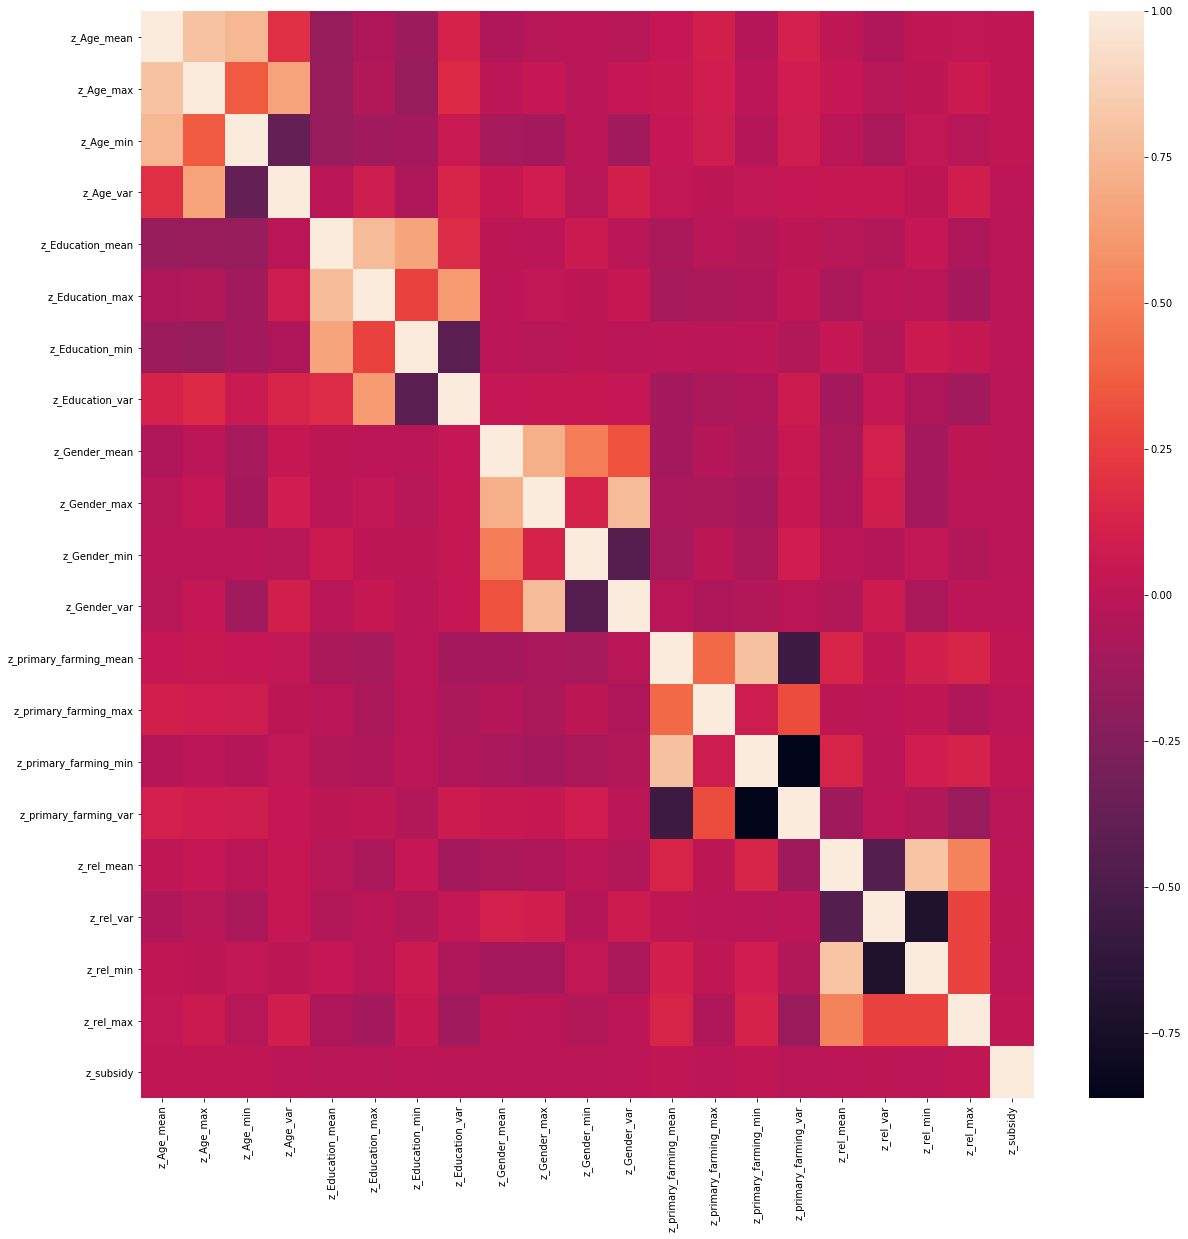

In [11]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data[explanatory_var].corr(), ax=ax)

#### Correlation between explanatory variables and response variable

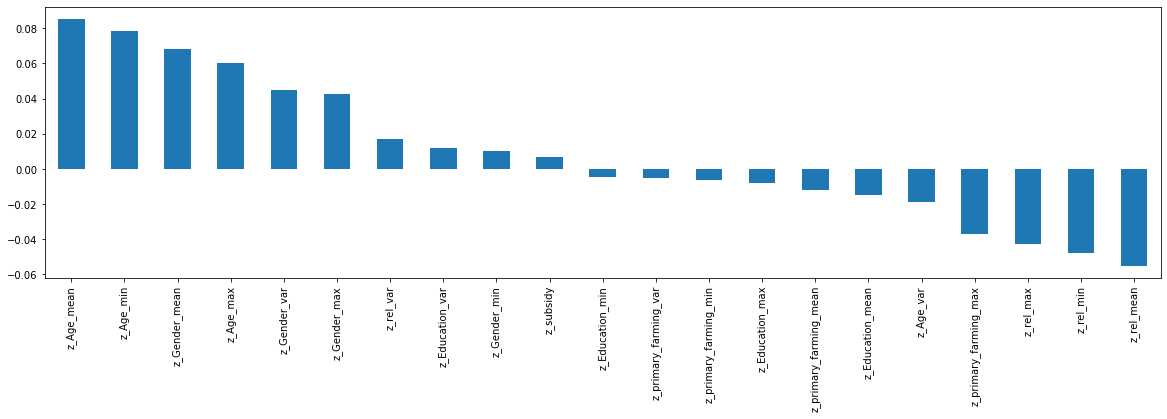

In [12]:
data[explanatory_var+[response_var]].corr()[response_var].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(20,5))

In [13]:
data[explanatory_var].corr().unstack().sort_values(ascending=False)[len(explanatory_var):]

z_rel_min              z_rel_mean                0.809215
z_rel_mean             z_rel_min                 0.809215
z_Age_max              z_Age_mean                0.802922
z_Age_mean             z_Age_max                 0.802922
z_primary_farming_min  z_primary_farming_mean    0.792055
                                                   ...   
z_primary_farming_var  z_primary_farming_mean   -0.566457
z_rel_var              z_rel_min                -0.715846
z_rel_min              z_rel_var                -0.715846
z_primary_farming_var  z_primary_farming_min    -0.861883
z_primary_farming_min  z_primary_farming_var    -0.861883
Length: 420, dtype: float64